# Training a Jet Tagging with **DNN** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a 
Dense Neural Network (DNN). The problem consists on identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on set of physics-motivated high-level features.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [ ]:
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset

In [4]:
! ls ../../tutorials/Data/JetDataset

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [50]:
target = np.array([])
features = np.array([])
featurenames = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['../../tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           '../../tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            '../../tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            '../../tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            '../../tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, features.shape)
f = h5py.File('../../tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5')
# These are the quantities we are dealing with
featurenames = np.array(f.get('jetFeatureNames'))
featurenames = featurenames[[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]]
print(featurenames[:])
f.close()

Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending ../../tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 16)
[b'j_zlogz' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt' b'j_c1_b2_mmdt'
 b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt' b'j_d2_b2_mmdt'
 b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt' b'j_m2_b2_mmdt'
 b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_mmdt' b'j_multiplicity']


The dataset consists of 50000 jets, each represented by 16 features

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del features, target

(33500, 16) (16500, 16) (33500, 5) (16500, 5)


# Explore Dataset

In [59]:
print("First entry")
print(X_train[:1,:])
print(y_train[:1,:])

First entry
[[-1.07134187e+00  1.60667032e-01  1.13031152e-03  8.18078115e-06
   6.81944890e-04  4.88114392e-06  6.03324711e-01  5.96659899e-01
   6.03324711e-01  3.72351781e-02  1.21174008e-02  7.32130697e-03
   6.35966808e-02  3.68872061e-02  3.96765041e+00  3.40000000e+01]]
[[1. 0. 0. 0. 0.]]
(16,)


(33500, 16)

In [60]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
# this function makes the histogram of a given quantity for the five classes
def makePlot(X, Y, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        # notice the use of numpy masking to select specific classes of jets
        my_data = X[np.argmax(Y, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:], 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log', nonposy='clip')    
    plt.legend(labelCat, fontsize=12, frameon=False)  
    plt.xlabel(str(input_featurenames, "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()
    #del fig, ax
    #return fig, ax

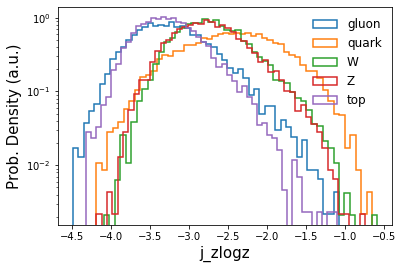

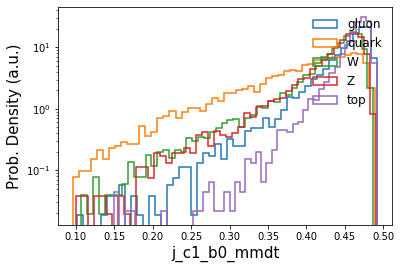

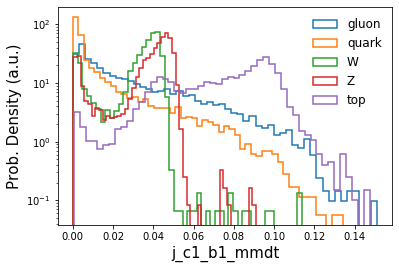

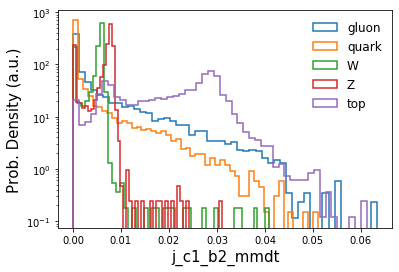

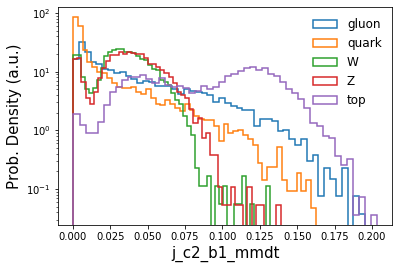

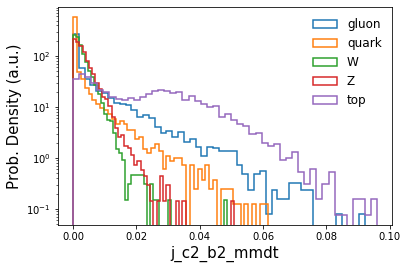

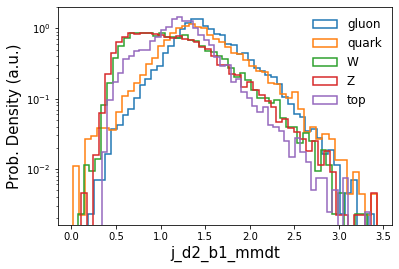

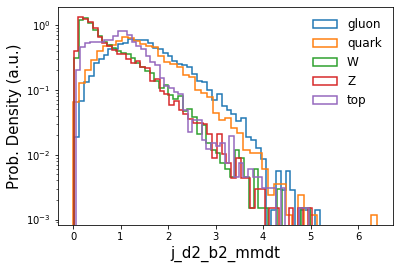

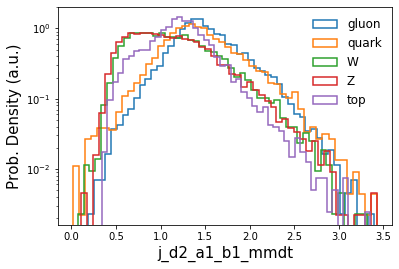

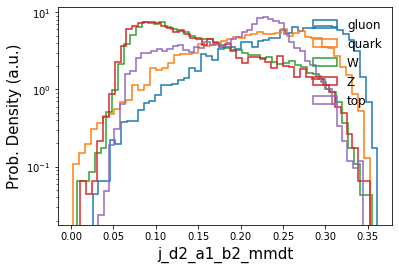

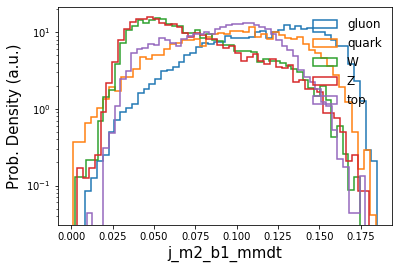

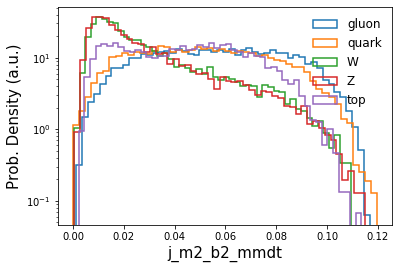

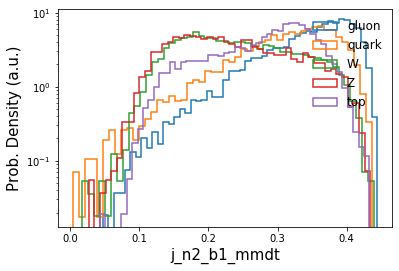

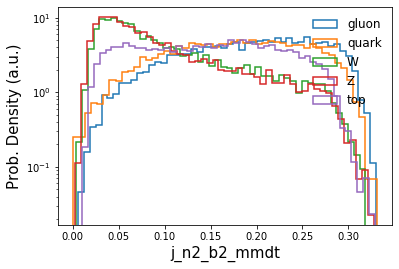

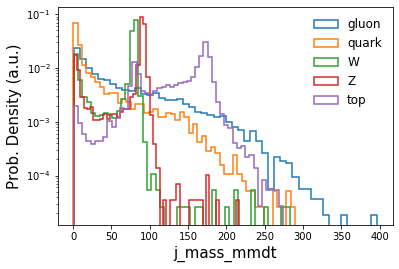

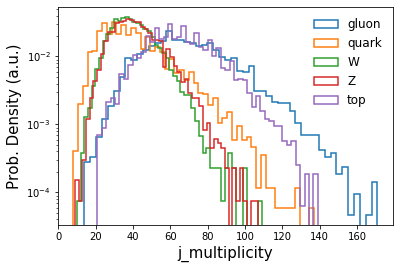

In [61]:
# we now plot all the features
for i in range(len(featurenames)):
    makePlot(X_train[:,i], y_train, featurenames[i])

# DNN model building

In [62]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [63]:
input_shape = X_train.shape[1]
dropoutRate = 0.25

In [64]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputArray, outputs=output)

W0112 00:49:04.952023 140704468780224 deprecation.py:506] From /Users/maurizio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [65]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 40)                680       
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210   

We now train the model

In [66]:
batch_size = 128
n_epochs = 50

In [67]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 33500 samples, validate on 16500 samples
Epoch 1/50
33500/33500 - 1s - loss: 2.2336 - val_loss: 1.5513
Epoch 2/50
33500/33500 - 0s - loss: 1.5660 - val_loss: 1.4909
Epoch 3/50
33500/33500 - 0s - loss: 1.5341 - val_loss: 1.4716
Epoch 4/50
33500/33500 - 0s - loss: 1.5152 - val_loss: 1.4464
Epoch 5/50
33500/33500 - 0s - loss: 1.5064 - val_loss: 1.4395
Epoch 6/50
33500/33500 - 0s - loss: 1.4958 - val_loss: 1.4356
Epoch 7/50
33500/33500 - 0s - loss: 1.4901 - val_loss: 1.4229
Epoch 8/50
33500/33500 - 0s - loss: 1.4802 - val_loss: 1.4115
Epoch 9/50
33500/33500 - 0s - loss: 1.4723 - val_loss: 1.4141
Epoch 10/50
33500/33500 - 0s - loss: 1.4658 - val_loss: 1.4018
Epoch 11/50
33500/33500 - 0s - loss: 1.4594 - val_loss: 1.3967
Epoch 12/50
33500/33500 - 0s - loss: 1.4530 - val_loss: 1.3936
Epoch 13/50
33500/33500 - 0s - loss: 1.4342 - val_loss: 1.3847
Epoch 14/50
33500/33500 - 0s - loss: 1.4239 - val_loss: 1.3832
Epoch 15/50
33500/33500 - 0s - loss: 1.4132 - val_loss: 1.3860
Epoch 16/50
33

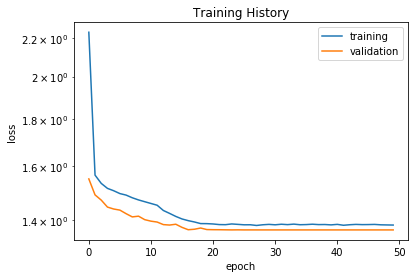

In [68]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

To save on disk the best model and training results:

model_json = model.to_json()

with open("tutorials/HiggsSchool/models/jetTagger_DNN.json", "w") as json_file:

    json_file.write(model_json)
    
model.save_weights("tutorials/HiggsSchool/models/jetTagger_DNN.h5")

# Building the ROC Curves

In [69]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

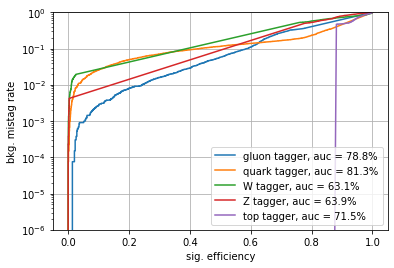

In [70]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()